## Read in Data

The data is stored as json with line for every book. This data contains every single book article on Wikipedia which was parsed in the [Downloading and Parsing Wikipedia Data Notebook](https://github.com/WillKoehrsen/wikipedia-data-science/blob/master/Downloading%20and%20Parsing%20Wikipedia%20Articles.ipynb).

In [1]:
from IPython.core.interactiveshell import InteractiveShell

# Set shell to show all lines of output
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from keras.utils import get_file

x = get_file('found_books_filtered.ndjson', 'https://raw.githubusercontent.com/WillKoehrsen/wikipedia-data-science/master/data/found_books_filtered.ndjson')

import json

books = []

with open(x, 'r') as fin:
    # Append each line to the books
    books = [json.loads(l) for l in fin]

# Remove non-book articles
books_with_wikipedia = [book for book in books if 'Wikipedia:' in book[0]]
books = [book for book in books if 'Wikipedia:' not in book[0]]
print(f'Found {len(books)} books.')

58925764/58925764 [==============================] - 0s 0us/step
Found 37020 books.


## Data Cleaning

There are a few articles that were caught which are clearly not books (feel free to check out these articles yourself).

In [4]:
[book[0] for book in books_with_wikipedia][:5]

['Wikipedia:Wikipedia Signpost/2014-06-25/Recent research',
 'Wikipedia:New pages patrol/Unpatrolled articles/December 2010',
 'Wikipedia:Templates for discussion/Log/2012 September 23',
 'Wikipedia:Articles for creation/Redirects/2012-10',
 'Wikipedia:Templates for discussion/Log/2012 October 4']

In [5]:
n = 21
books[n][0], books[n][1], books[n][2][:5], books[n][3][:5], books[n][3][:5], books[n][4], books[n][5]

('Limonov (novel)',
 {'name': 'Limonov',
  'author': 'Emmanuel Carrère',
  'translator': 'John Lambert',
  'country': 'France',
  'language': 'French',
  'publisher': 'P.O.L.',
  'pub_date': '2011',
  'english_pub_date': '2014',
  'pages': '488',
  'isbn': '978-2-8180-1405-9'},
 ['Emmanuel Carrère',
  'biographical novel',
  'Emmanuel Carrère',
  'Eduard Limonov',
  'Prix de la langue française'],
 ['http://www.lefigaro.fr/flash-actu/2011/10/05/97001-20111005FILWWW00615-le-prix-de-la-langue-francaise-a-e-carrere.php',
  'http://www.lexpress.fr/culture/livre/emmanuel-carrere-prix-renaudot-2011_1046819.html',
  'http://limonow.de/carrere/index.html',
  'http://www.tout-sur-limonov.fr/222318809'],
 ['http://www.lefigaro.fr/flash-actu/2011/10/05/97001-20111005FILWWW00615-le-prix-de-la-langue-francaise-a-e-carrere.php',
  'http://www.lexpress.fr/culture/livre/emmanuel-carrere-prix-renaudot-2011_1046819.html',
  'http://limonow.de/carrere/index.html',
  'http://www.tout-sur-limonov.fr/222318

We will only use the wikilinks, which are saved as the third element (index 2) for each book.

In [6]:
book_index = {book[0]: idx for idx, book in enumerate(books)}
index_book = {idx: book for book, idx in book_index.items()}

book_index['Anna Karenina']
index_book[22494]

22494

'Anna Karenina'

In [7]:
from itertools import chain

wikilinks = list(chain(*[book[2] for book in books]))
print(f"There are {len(set(wikilinks))} unique wikilinks.")

There are 311276 unique wikilinks.


How many of these are links to other books?

In [8]:
wikilinks_other_books = [link for link in wikilinks if link in book_index.keys()]
print(f"There are {len(set(wikilinks_other_books))} unique wikilinks to other books.")

There are 17032 unique wikilinks to other books.


In [9]:
from collections import Counter, OrderedDict

def count_items(l):
    """Return ordered dictionary of counts of objects in `l`"""

    # Create a counter object
    counts = Counter(l)

    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)

    return counts

In [10]:
# Find set of wikilinks for each book and convert to a flattened list
unique_wikilinks = list(chain(*[list(set(book[2])) for book in books]))

wikilink_counts = count_items(unique_wikilinks)
list(wikilink_counts.items())[:10]

[('Hardcover', 7489),
 ('Paperback', 7311),
 ('Wikipedia:WikiProject Books', 6043),
 ('Wikipedia:WikiProject Novels', 6015),
 ('English language', 4185),
 ('United States', 3060),
 ('Science fiction', 3030),
 ('The New York Times', 2727),
 ('science fiction', 2502),
 ('novel', 1979)]

In [11]:
wikilinks = [link.lower() for link in unique_wikilinks]
print(f"There are {len(set(wikilinks))} unique wikilinks.")

wikilink_counts = count_items(wikilinks)
list(wikilink_counts.items())[:10]

There are 297624 unique wikilinks.


[('paperback', 8740),
 ('hardcover', 8648),
 ('wikipedia:wikiproject books', 6043),
 ('wikipedia:wikiproject novels', 6016),
 ('science fiction', 5665),
 ('english language', 4248),
 ('united states', 3063),
 ('novel', 2983),
 ('the new york times', 2742),
 ('fantasy', 2003)]

In [12]:
to_remove = ['hardcover', 'paperback', 'hardback', 'e-book', 'wikipedia:wikiproject books', 'wikipedia:wikiproject novels']
for t in to_remove:
    wikilinks.remove(t)
    _ = wikilink_counts.pop(t)

In [13]:
# Limit to greater than 3 links
links = [t[0] for t in wikilink_counts.items() if t[1] >= 4]
print(len(links))

41758


In [14]:
# Find set of book wikilinks for each book
unique_wikilinks_books = list(chain(*[list(set(link for link in book[2] if link in book_index.keys())) for book in books]))

# Count the number of books linked to by other books
wikilink_book_counts = count_items(unique_wikilinks_books)
list(wikilink_book_counts.items())[:10]

[('The Encyclopedia of Science Fiction', 127),
 ('The Discontinuity Guide', 104),
 ('The Encyclopedia of Fantasy', 63),
 ('Dracula', 55),
 ('Encyclopædia Britannica', 51),
 ('Nineteen Eighty-Four', 51),
 ('Don Quixote', 49),
 ('The Wonderful Wizard of Oz', 49),
 ("Alice's Adventures in Wonderland", 47),
 ('Jane Eyre', 39)]

In [15]:
for book in books:
    if 'The New York Times' in book[2] and 'New York Times' in book[2]:
        print(book[0], book[2])
        break

The Big Picture: Who Killed Hollywood? and Other Essays ['Wikipedia:WikiProject Novels', 'Wikipedia:WikiProject Books', 'William Goldman', 'United States', 'English language', 'William Goldman', 'Michael Sragow', 'Good Will Hunting', 'Robin Williams', 'Matt Damon', 'The New York Times', 'The New York Times Company', 'New York Times', 'Category:Cinema of the United States', 'Category:Film production', 'Category:2000 books', 'Category:Books about films', 'Category:Books by William Goldman', 'Category:Show business memoirs']


In [16]:
wikilink_counts.get('the new york times')
wikilink_counts.get('new york times')

2742

996

In [17]:
link_index = {link: idx for idx, link in enumerate(links)}
index_link = {idx: link for link, idx in link_index.items()}

link_index['the economist']
index_link[300]
print(f'There are {len(link_index)} wikilinks that will be used.')

300

'the economist'

There are 41758 wikilinks that will be used.


In [18]:
pairs = []

# Iterate through each book
for book in books:
    # Iterate through the links in the book
    pairs.extend((book_index[book[0]], link_index[link.lower()]) for link in book[2] if link.lower() in links)

len(pairs), len(links), len(books)
pairs[5000]

(772798, 41758, 37020)

(321, 232)

In [19]:
index_book[pairs[5000][0]], index_link[pairs[5000][1]]

('Slaves in the Family', 'category:american biographies')

In [20]:
index_book[pairs[900][0]], index_link[pairs[900][1]]

('The Man Who Watched the Trains Go By (novel)',
 'category:belgian novels adapted into films')

Later on we'll create the negative examples by randomly sampling from the links and the books and making sure the resulting pair is not in `pairs`.

In [21]:
pairs_set = set(pairs)

Just for fun, let's look at the (book, link) pairs that are represented most often in the data.

In [22]:
x = Counter(pairs)
sorted(x.items(), key = lambda x: x[1], reverse = True)[:5]

[((13337, 31112), 85),
 ((31899, 65), 77),
 ((25899, 8851), 61),
 ((1851, 2629), 57),
 ((25899, 30465), 53)]

In [23]:
index_book[13337], index_link[31111]
index_book[31899], index_link[65]
index_book[25899], index_link[30465]

("France's Songs of the Bards of the Tyne - 1850", 'robert nunn (songwriter)')

('The Early Stories: 1953–1975', 'the new yorker')

('Marthandavarma (novel)', 'kerala sahitya akademi')

There's nothing wrong with books that link to the same page many times. They are just more likely to be trained on since there are more of them.

In [24]:
import numpy as np
import random
random.seed(100)

def generate_batch(pairs, n_positive = 50, negative_ratio = 1.0, classification = False):
    """Generate batches of samples for training"""
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))

    # Adjust label based on task
    if classification:
        neg_label = 0
    else:
        neg_label = -1

    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, (book_id, link_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (book_id, link_id, 1)

        # Increment idx by 1
        idx += 1

        # Add negative examples until reach batch size
        while idx < batch_size:

            # random selection
            random_book = random.randrange(len(books))
            random_link = random.randrange(len(links))

            # Check to make sure this is not a positive example
            if (random_book, random_link) not in pairs_set:

                # Add to batch and increment index
                batch[idx, :] = (random_book, random_link, neg_label)
                idx += 1

        # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'book': batch[:, 0], 'link': batch[:, 1]}, batch[:, 2]

To get a new batch, call `next` on the generator.

In [25]:
next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

({'book': array([25757., 29814., 28410., 22162.,  7206.,  6895.]),
  'link': array([22920., 11452., 33217.,  5588., 34924.,   260.])},
 array([-1., -1., -1.,  1., -1.,  1.]))

In [26]:
x, y = next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

# Show a few example training pairs
for label, b_idx, l_idx in zip(y, x['book'], x['link']):
    print(f'Book: {index_book[b_idx]:30} Link: {index_link[l_idx]:40} Label: {label}')

Book: The Soul of the Robot          Link: house of night                           Label: -1.0
Book: Deep Six (novel)               Link: president of the united states           Label: 1.0
Book: Soul Music (novel)             Link: peter crowther                           Label: -1.0
Book: The Counterfeit Man            Link: gerald gardner (wiccan)                  Label: -1.0
Book: Bag of Bones                   Link: category:novels by stephen king          Label: 1.0
Book: Des Imagistes                  Link: august strindberg                        Label: -1.0


The neural network will take in the book index and the link index and try to embed them in such a way that it can predict the label from the embeddings.

In [27]:
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model

In [28]:
def book_embedding_model(embedding_size = 50, classification = False):
    """Model to embed books and wikilinks using the functional API.
       Trained to discern if a link is present in a article"""

    # Both inputs are 1-dimensional
    book = Input(name = 'book', shape = [1])
    link = Input(name = 'link', shape = [1])

    # Embedding the book (shape will be (None, 1, 50))
    book_embedding = Embedding(name = 'book_embedding',
                               input_dim = len(book_index),
                               output_dim = embedding_size)(book)

    # Embedding the link (shape will be (None, 1, 50))
    link_embedding = Embedding(name = 'link_embedding',
                               input_dim = len(link_index),
                               output_dim = embedding_size)(link)

    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([book_embedding, link_embedding])

    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)

    # If classifcation, add extra layer and loss function is binary cross entropy
    if classification:
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    # Otherwise loss function is mean squared error
    else:
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'mse')

    return model

# Instantiate model and show parameters
model = book_embedding_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 book (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 link (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 book_embedding (Embedding)     (None, 1, 50)        1851000     ['book[0][0]']                   
                                                                                                  
 link_embedding (Embedding)     (None, 1, 50)        2087900     ['link[0][0]']                   
                                                                                              

In [29]:
n_positive = 1024

gen = generate_batch(pairs, n_positive, negative_ratio = 2)

# Train
h = model.fit_generator(gen, epochs = 15,
                        steps_per_epoch = len(pairs) // n_positive,
                        verbose = 2)

Epoch 1/15


<ipython-input-29-c795be47e197>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model.fit_generator(gen, epochs = 15,


754/754 - 45s - loss: 0.9569 - 45s/epoch - 59ms/step
Epoch 2/15
754/754 - 43s - loss: 0.7203 - 43s/epoch - 57ms/step
Epoch 3/15
754/754 - 48s - loss: 0.5032 - 48s/epoch - 63ms/step
Epoch 4/15
754/754 - 43s - loss: 0.4621 - 43s/epoch - 57ms/step
Epoch 5/15
754/754 - 44s - loss: 0.4450 - 44s/epoch - 58ms/step
Epoch 6/15
754/754 - 47s - loss: 0.4359 - 47s/epoch - 63ms/step
Epoch 7/15
754/754 - 44s - loss: 0.4293 - 44s/epoch - 58ms/step
Epoch 8/15
754/754 - 50s - loss: 0.4253 - 50s/epoch - 66ms/step
Epoch 9/15
754/754 - 60s - loss: 0.4220 - 60s/epoch - 79ms/step
Epoch 10/15
754/754 - 54s - loss: 0.4195 - 54s/epoch - 71ms/step
Epoch 11/15
754/754 - 44s - loss: 0.4169 - 44s/epoch - 58ms/step
Epoch 12/15
754/754 - 45s - loss: 0.4154 - 45s/epoch - 59ms/step
Epoch 13/15
754/754 - 43s - loss: 0.4136 - 43s/epoch - 58ms/step
Epoch 14/15
754/754 - 44s - loss: 0.4126 - 44s/epoch - 59ms/step
Epoch 15/15
754/754 - 44s - loss: 0.4110 - 44s/epoch - 59ms/step


In [30]:
model.save('first_attempt.h5')

In [31]:
# Extract embeddings
book_layer = model.get_layer('book_embedding')
book_weights = book_layer.get_weights()[0]
book_weights.shape

(37020, 50)

In [32]:
book_weights = book_weights / np.linalg.norm(book_weights, axis = 1).reshape((-1, 1))
book_weights[0][:10]
np.sum(np.square(book_weights[0]))

array([ 0.15123607,  0.2598969 , -0.0895264 , -0.06556121, -0.11815421,
       -0.14634375,  0.18061672, -0.02183779,  0.19096173, -0.12124863],
      dtype=float32)

1.0

Normalize just means divide each vector by the square root of the sum of squared components.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

def find_similar(name, weights, index_name = 'book', n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""

    # Select index and reverse index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link

    # Check to make sure `name` is in index
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return

    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)

    # Plot results if specified
    if plot:

        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)

        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)

        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))

        data = pd.DataFrame({'distance': distances}, index = items)

        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');

        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)

        return None

    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]

        print(f'{index_name.capitalize()}s furthest from {name}.\n')

    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]

        # Need distances later on
        if return_dist:
            return dists, closest


        print(f'{index_name.capitalize()}s closest to {name}.\n')

    # Need distances later on
    if return_dist:
        return dists, closest


    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])

    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')



In [34]:
find_similar('War and Peace', book_weights)

Books closest to War and Peace.

Book: War and Peace                 Similarity: 1.0
Book: Demons (Dostoevsky novel)     Similarity: 0.91
Book: Anna Karenina                 Similarity: 0.91
Book: Crime and Punishment          Similarity: 0.9
Book: The Master and Margarita      Similarity: 0.9
Book: Dead Souls                    Similarity: 0.9
Book: Candide                       Similarity: 0.88
Book: The Idiot                     Similarity: 0.88
Book: Poor Folk                     Similarity: 0.88
Book: The Hunchback of Notre-Dame   Similarity: 0.88


It works! The most similar books make sense at least for _War and Peace._



In [35]:
find_similar('War and Peace', book_weights, least = True, n = 5)

Books furthest from War and Peace.

Book: Profit from the Core       Similarity: -0.54
Book: Lords of Darkness          Similarity: -0.54
Book: Siege of Darkness          Similarity: -0.54
Book: Arms and Equipment Guide   Similarity: -0.54
Book: Condemnation (novel)       Similarity: -0.56


The least similar books are quite a grab bag!

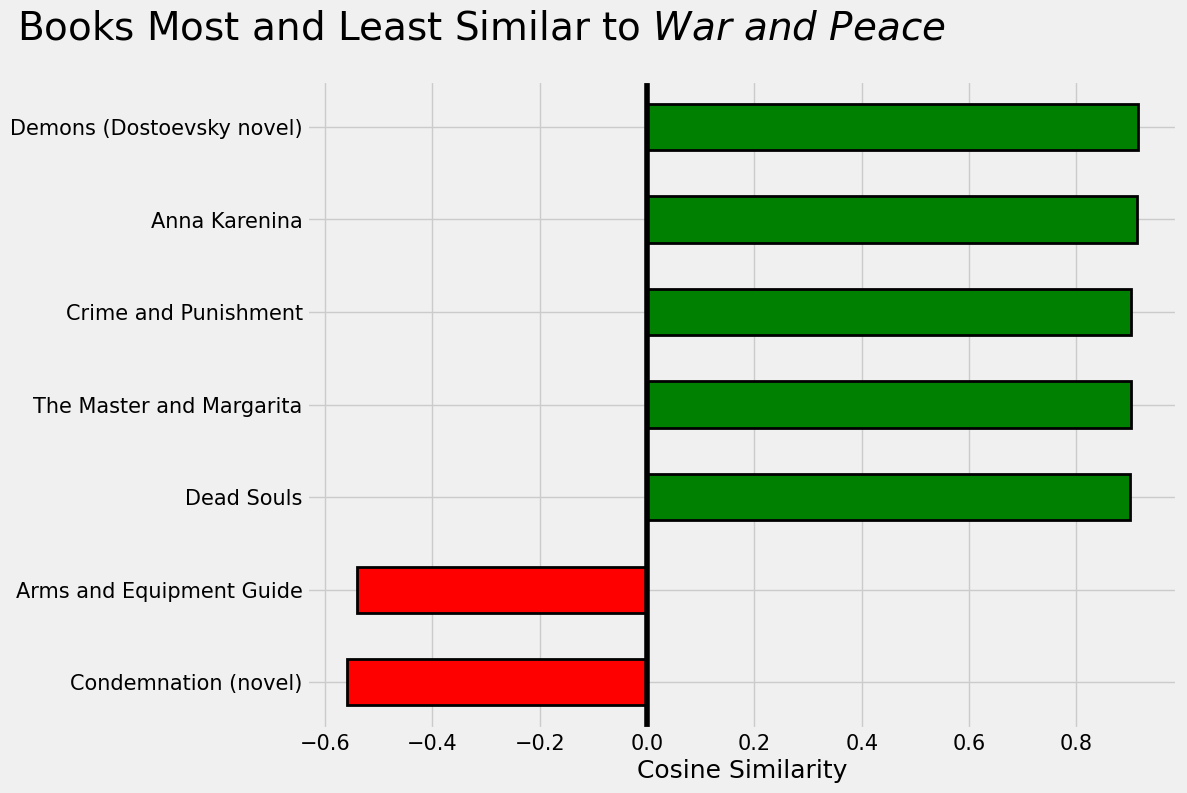

In [36]:
find_similar('War and Peace', book_weights, n = 5, plot = True)

In [37]:
find_similar('The Fellowship of the Ring', book_weights, n = 5)

Books closest to The Fellowship of the Ring.

Book: The Fellowship of the Ring   Similarity: 1.0
Book: The Return of the King       Similarity: 0.96
Book: The Silmarillion             Similarity: 0.95
Book: The Two Towers               Similarity: 0.91
Book: Beren and Lúthien            Similarity: 0.9


It doesn't work perfectly for every book as we can see.

In [38]:
find_similar('Artificial Intelligence: A Modern Approach', book_weights, n = 5)

Books closest to Artificial Intelligence: A Modern Approach.

Book: Artificial Intelligence: A Modern Approach            Similarity: 1.0
Book: Structure and Interpretation of Classical Mechanics   Similarity: 0.96
Book: Computer Graphics: Principles and Practice            Similarity: 0.96
Book: TCP/IP Illustrated                                    Similarity: 0.95
Book: Essentials of Programming Languages                   Similarity: 0.95


In [39]:
find_similar('Weapons of Math Destruction', book_weights, n = 5)

Books closest to Weapons of Math Destruction.

Book: Weapons of Math Destruction           Similarity: 1.0
Book: The Alchemy of Race and Rights        Similarity: 0.95
Book: Linked: The New Science of Networks   Similarity: 0.95
Book: Hurst's the Heart                     Similarity: 0.94
Book: The Lucifer Principle                 Similarity: 0.94


In [40]:
find_similar('Bully for Brontosaurus', book_weights, n = 5)

Books closest to Bully for Brontosaurus.

Book: Bully for Brontosaurus          Similarity: 1.0
Book: Eight Little Piggies            Similarity: 0.97
Book: The Lying Stones of Marrakech   Similarity: 0.96
Book: Ever Since Darwin               Similarity: 0.96
Book: I Have Landed                   Similarity: 0.96


The algorithm has spoken!

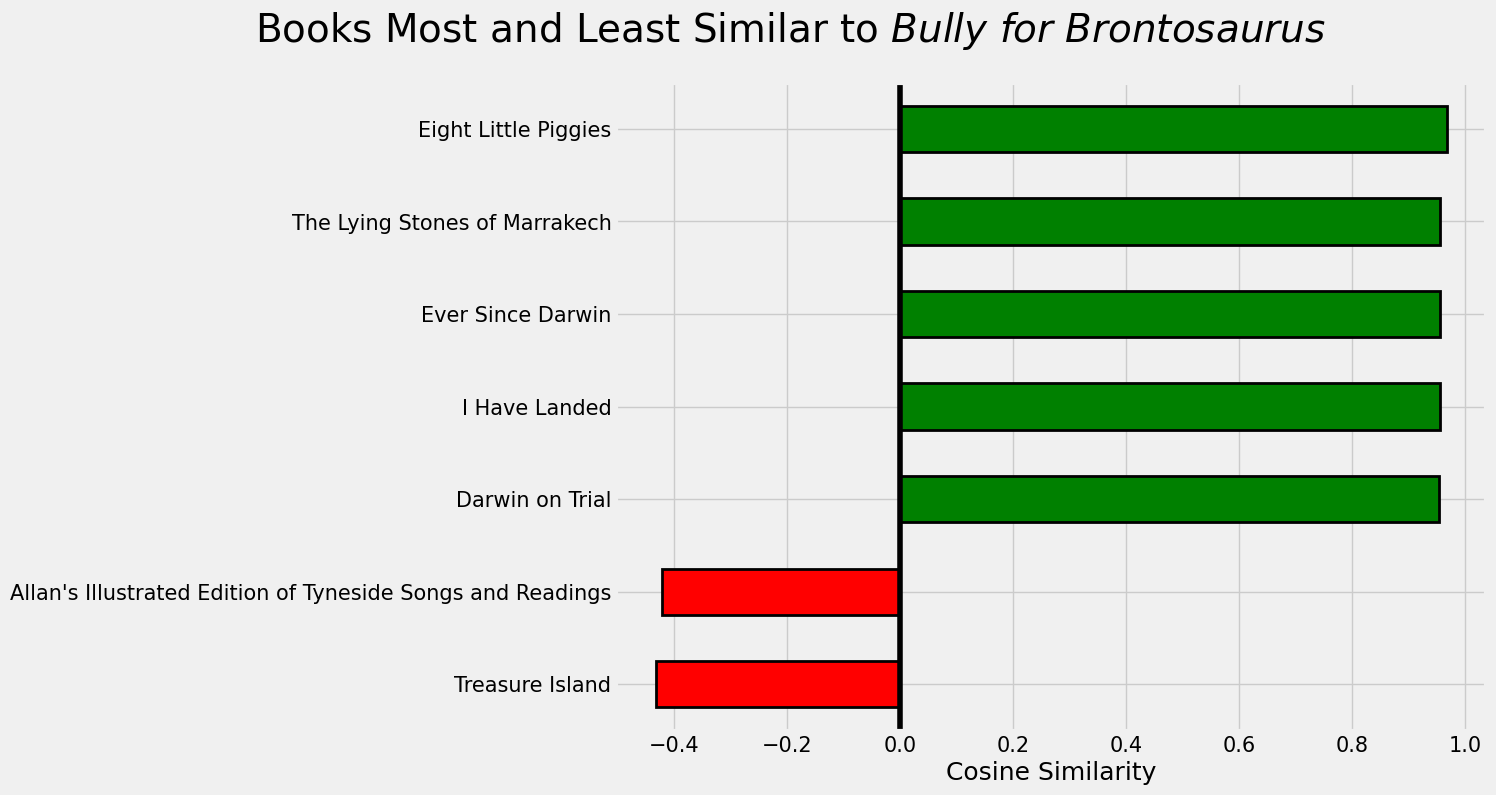

In [41]:
find_similar('Bully for Brontosaurus', book_weights, n = 5, plot = True)

In [42]:
def extract_weights(name, model):
    """Extract weights from a neural network model"""

    # Extract weights
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]

    # Normalize
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

In [43]:
link_weights = extract_weights('link_embedding', model)

We can use the same `find_similar` function to find the most similar links to a given link.

In [44]:
find_similar('science fiction', link_weights, index_name = 'page')

Pages closest to science fiction.

Page: science fiction                            Similarity: 1.0
Page: category:american science fiction novels   Similarity: 0.98
Page: tor books                                  Similarity: 0.92
Page: ballantine books                           Similarity: 0.91
Page: bantam books                               Similarity: 0.91
Page: category:doubleday (publisher) books       Similarity: 0.9
Page: anthology                                  Similarity: 0.89
Page: fantasy                                    Similarity: 0.88
Page: victor gollancz ltd                        Similarity: 0.88
Page: category:ballantine books books            Similarity: 0.88


Based on my knowledge, it appears the neural network embeddings are also a good representation of the pages! Not only can we find the most similar books to a given book, but if we have a category of books that we enjoy, we can find another category that is similar.

In [45]:
find_similar('biography', link_weights, index_name = 'page')

Pages closest to biography.

Page: biography                             Similarity: 1.0
Page: autobiography                         Similarity: 0.94
Page: non-fiction                           Similarity: 0.93
Page: category:american non-fiction books   Similarity: 0.93
Page: category:2003 books                   Similarity: 0.92
Page: category:english-language books       Similarity: 0.92
Page: category:2005 books                   Similarity: 0.9
Page: memoir                                Similarity: 0.9
Page: category:2007 books                   Similarity: 0.89
Page: category:2010 non-fiction books       Similarity: 0.89


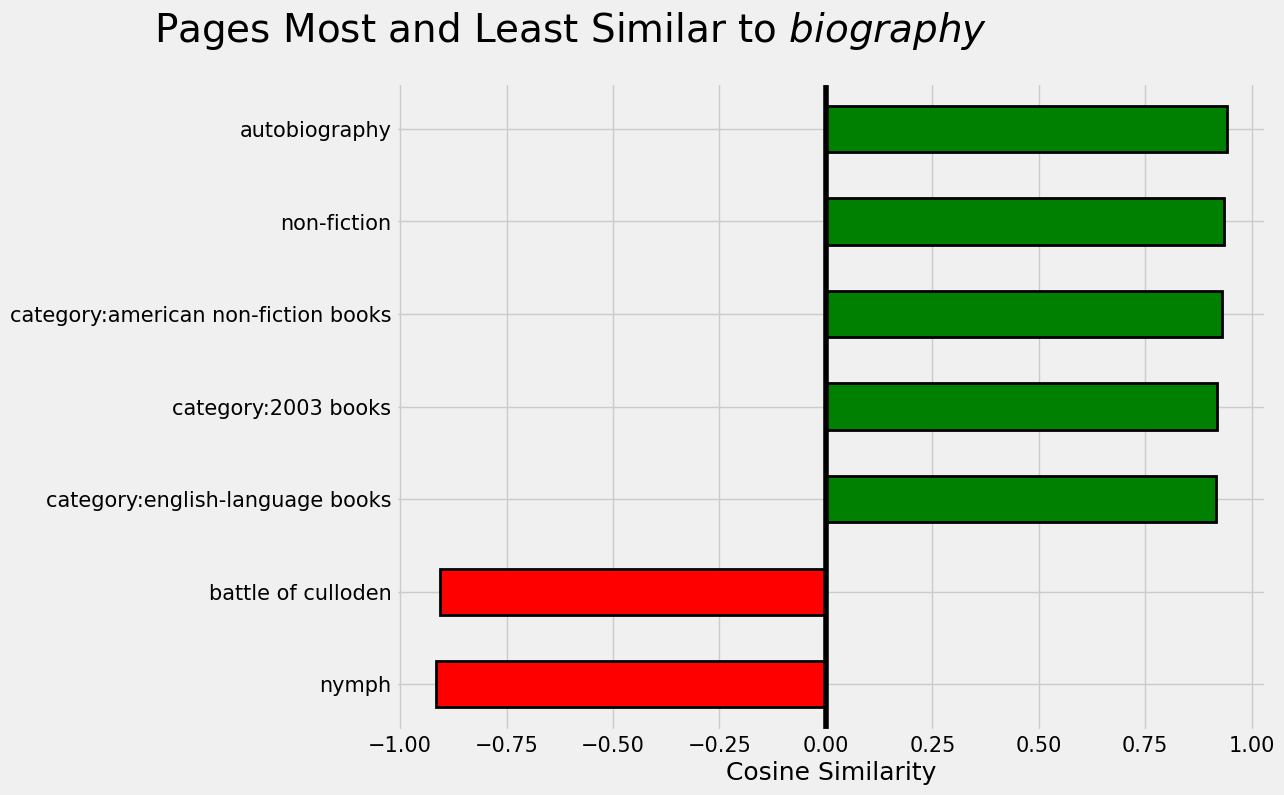

In [46]:
find_similar('biography', link_weights, index_name = 'page', n = 5, plot = True)

Now you not only know what books to look for, you know the books to avoid for a given category!

In [47]:
find_similar('new york city', link_weights, index_name = 'page', n = 5)

Pages closest to new york city.

Page: new york city                    Similarity: 1.0
Page: the new york times               Similarity: 0.96
Page: alfred a. knopf                  Similarity: 0.96
Page: category:alfred a. knopf books   Similarity: 0.95
Page: category:random house books      Similarity: 0.95


In [48]:
model_class = book_embedding_model(50, classification = True)
gen = generate_batch(pairs, n_positive, negative_ratio=2, classification = True)

In [49]:
# Train the model to learn embeddings
h = model_class.fit_generator(gen, epochs = 15, steps_per_epoch= len(pairs) // n_positive,
                            verbose = 0)

<ipython-input-49-84630604888e>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model_class.fit_generator(gen, epochs = 15, steps_per_epoch= len(pairs) // n_positive,


We'll go through the same process, extracting the weights and finding similar books based on the embedding space representation.

In [50]:
model_class.save('first_attempt_class.h5')

In [51]:
book_weights_class = extract_weights('book_embedding', model_class)
book_weights_class.shape

(37020, 50)

In [52]:
find_similar('War and Peace', book_weights_class, n = 5)

Books closest to War and Peace.

Book: War and Peace              Similarity: 1.0
Book: Doctor Zhivago (novel)     Similarity: 0.82
Book: Anna Karenina              Similarity: 0.8
Book: The Master and Margarita   Similarity: 0.79
Book: Dead Souls                 Similarity: 0.74


In [53]:
find_similar('The Fellowship of the Ring', book_weights_class, n = 5)

Books closest to The Fellowship of the Ring.

Book: The Fellowship of the Ring   Similarity: 1.0
Book: The Two Towers               Similarity: 0.89
Book: The Return of the King       Similarity: 0.89
Book: The Silmarillion             Similarity: 0.82
Book: Bilbo's Last Song            Similarity: 0.8


In [54]:
find_similar('The Better Angels of Our Nature', book_weights_class, n = 5)

Books closest to The Better Angels of Our Nature.

Book: The Better Angels of Our Nature   Similarity: 1.0
Book: 12 Rules for Life                 Similarity: 0.75
Book: Letter to a Christian Nation      Similarity: 0.75
Book: A Natural History of Rape         Similarity: 0.73
Book: Enlightenment Now                 Similarity: 0.72


In [55]:
link_weights_class = extract_weights('link_embedding', model_class)

In [56]:
find_similar('the washington post', link_weights_class, index_name = 'page', n = 5)

Pages closest to the washington post.

Page: the washington post   Similarity: 1.0
Page: los angeles times     Similarity: 0.94
Page: washington post       Similarity: 0.94
Page: the new york times    Similarity: 0.92
Page: time (magazine)       Similarity: 0.92


In [57]:
find_similar('category:almanacs', link_weights_class, index_name = 'page', n = 5)

Pages closest to category:almanacs.

Page: category:almanacs                                Similarity: 1.0
Page: arts                                             Similarity: 0.68
Page: category:single volume general reference works   Similarity: 0.66
Page: almanac                                          Similarity: 0.65
Page: category:dorling kindersley books                Similarity: 0.64


In [58]:
find_similar('steven pinker', link_weights_class, index_name = 'page', n = 5)

Pages closest to steven pinker.

Page: steven pinker             Similarity: 1.0
Page: evolutionary psychology   Similarity: 0.81
Page: reductionism              Similarity: 0.79
Page: stephen jay gould         Similarity: 0.79
Page: h. allen orr              Similarity: 0.78


In [59]:
find_similar('richard dawkins', link_weights_class, index_name = 'page', n = 5)

Pages closest to richard dawkins.

Page: richard dawkins        Similarity: 1.0
Page: creationism            Similarity: 0.8
Page: stephen jay gould      Similarity: 0.79
Page: the blind watchmaker   Similarity: 0.79
Page: natural selection      Similarity: 0.78


Looks like I have some new topics to explore!

In [60]:
from sklearn.manifold import TSNE
from umap import UMAP

ModuleNotFoundError: ignored

In [ ]:
def reduce_dim(weights, components = 3, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric = 'cosine').fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return UMAP(n_components=components, metric = 'cosine',
                    init = 'random', n_neighbors = 5).fit_transform(weights)

In [ ]:
book_r = reduce_dim(book_weights_class, components = 2, method = 'tsne')
book_r.shape

We've now taken the initial 37,000 dimension book vector and reduced it to just 2 dimensions.

In [ ]:
InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))
plt.plot(book_r[:, 0], book_r[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Book Embeddings Visualized with TSNE');

There do appear to be a few noticeable clumps. However, it's difficult to derive any meaning from this plot since we aren't distinguishing books in any way.

In [ ]:
book_ru = reduce_dim(book_weights_class, components = 2, method = 'umap')

plt.figure(figsize = (10, 8))
plt.plot(book_ru[:, 0], book_ru[:, 1], 'g.');
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title('Book Embeddings Visualized with UMAP');

### Book Embeddings by Genre

The above graphs are difficult to interpret. Let's plot the embeddings by the `genre` which is contained in the `Infobox` template data for each book. We'll limit it to the 10 most popular genres.

In [ ]:
info = list(chain(*[set(book[1]) for book in books]))
info_counts = count_items(info)
list(info_counts.items())[:10]

In [ ]:
genres = [book[1].get('genre', 'None').lower() for book in books]

# Remove genres not found
genre_counts = count_items(genres)
del genre_counts['none']
list(genre_counts.items())[:10]

In [ ]:
# Include 10 most popular genres
genre_to_include = list(genre_counts.keys())[:10]

In [ ]:
idx_include = []
genres = []

for i, book in enumerate(books):
    if 'genre' in book[1].keys():
        if book[1]['genre'].lower() in genre_to_include:
            idx_include.append(i)
            genres.append(book[1]['genre'].capitalize())

len(idx_include)

Now we need to map the genres to integers to plot them as colors.

In [ ]:
ints, gen = pd.factorize(genres)
gen[:5]

Finally, we can plot the embedding colored by the genre

In [ ]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1],
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / ((10) * 2), lab, ha='left', va='center')
cbar.ax.set_title('Genre', loc = 'left')


plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Book Embeddings');

The books do seem to be slightly separated based on the genre. The categories aren't exactly that helpful but we did what we could! We can also try UMAP.

In [ ]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(book_ru[idx_include, 0], book_ru[idx_include, 1],
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / ((10) * 2), lab, ha='left', va='center')
cbar.ax.set_title('Genre', loc = 'left')


plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title('UMAP Visualization of Book Embeddings');

There doesn't appear to be much separation between the categories in the UMAP clustering. There are a lot of parameters to play around with in UMAP, and changing some of them might result in better clusters.

## Most Popular Books in Embedding

Let's see the embedding labeled with the 10 books most often mentioned by other books.

In [ ]:
plt.figure(figsize = (14, 12))

# Plot all books
plt.scatter(book_r[:, 0], book_r[:, 1], marker = '.', color = 'lightblue', alpha = 0.2)

# Plot genres
plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1],
            c = ints, cmap = plt.cm.tab10, alpha = 0.6)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / ((10) * 2), lab, ha='left', va='center')

cbar.ax.set_title('Genre', loc = 'left')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Book Embeddings');

for book in list(wikilink_book_counts.keys())[:10]:

    x, y = book_r[book_index[book], 0], book_r[book_index[book], 1];
    # Italize book title using latex
    s =  ''.join([' $\it{' + word + '}$' for word in book.split()])
    _ = plt.scatter(x, y, s = 250, color = 'r',
                    marker = '*', edgecolor = 'k')
    _ = plt.text(x - 10, y + 2, s, fontsize = 14);


The `Encyclopedia`s of Science Fiction and Fantasy have nearly perfect overlap.

In [ ]:
book_r[book_index['The Encyclopedia of Science Fiction']]

In [ ]:
book_r[book_index['The Encyclopedia of Fantasy']]

Let's make a function that can color the plot by any attribute in the book infobox. We already saw this with the genre, but we can extend it to the author or any other information.

In [ ]:
def plot_by_attribute(attribute):
    """Color book embedding by `attribute`"""
    # Find all the attribute values
    attrs = [book[1].get(attribute, 0) for book in books]

    # Remove attributes not found
    attr_counts = count_items(attrs)
    del attr_counts[0]

    # Include 10 most popular attributes
    attr_to_include, counts = list(attr_counts.keys())[:10], list(attr_counts.values())[:10]

    idx_include = []
    attributes = []

    # Iterate through books searching for the attribute
    for i, book in enumerate(books):
        # Limit to books with the attribute
        if attribute in book[1].keys():
            # Limit to attribute in the 10 most popular
            if book[1][attribute] in attr_to_include:
                idx_include.append(i)
                attributes.append(book[1][attribute])

    # Map to integers
    ints, attrs = pd.factorize(attributes)
    plt.figure(figsize = (12, 10))

    plt.scatter(book_r[:, 0], book_r[:, 1], marker = '.', color = 'lightblue', alpha = 0.2)

    # Plot embedding with only specific attribute highlighted
    plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1], alpha = 0.6,
                c = ints, cmap = plt.cm.tab10, marker = 'o', s = 50)

    # Add colorbar and appropriate labels
    cbar = plt.colorbar()
    cbar.set_ticks([])
    tick_labels = [f'{attr}: {count}' for attr, count in zip(attr_to_include, counts)]
    # Labeling
    for j, lab in enumerate(tick_labels):
        cbar.ax.text(1, (2 * j + 1) / ((10) * 2), lab, ha='left', va='center')
    cbar.ax.set_title(f'{attribute.capitalize()}: Count', loc = 'left')


    plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title(f'Book Embeddings with {attribute.capitalize()}');

In [ ]:
plot_by_attribute('genre')

In [ ]:
plot_by_attribute('author')

In [ ]:
plot_by_attribute('country')

In [ ]:
plot_by_attribute('language')

In [ ]:
def plot_closest(item, weights, index_name, n, plot_data):
    """Plot n most closest items to item"""

    # Find the closest items
    dist, closest = find_similar(item, weights, index_name, n, return_dist=True)

    # Choose mapping for look up
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link

    plt.figure(figsize = (10, 9))
    plt.rcParams['font.size'] = 14

    # Limit distances
    dist = dist[closest]

    # Plot all of the data
    plt.scatter(plot_data[:, 0], plot_data[:, 1], alpha = 0.1, color = 'goldenrod')

    # Plot the item
    plt.scatter(plot_data[closest[-1], 0], plot_data[closest[-1], 1], s = 600, edgecolor = 'k', color = 'forestgreen')

    # Plot the closest items
    p = plt.scatter(plot_data[closest[:-1], 0], plot_data[closest[:-1], 1],
                c = dist[:-1], cmap = plt.cm.RdBu_r, s = 200, alpha = 1, marker = '*')

    # Colorbar management
    cbar = plt.colorbar()
    cbar.set_ticks([])

    tick_labels = []
    # Tick labeling for colorbar
    for idx, distance in zip(closest[:-1], dist[:-1]):
        name_str = ''
        for word in rindex[idx].split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        name_str += ': ' + str(round(distance, 2))
        tick_labels.append(name_str)

    for j, lab in enumerate(tick_labels):
        cbar.ax.text(1, (2 * j + 1) / ((n - 1) * 2), lab, ha='left', va='center', size = 12)
    cbar.ax.set_title(f'{index_name.capitalize()} and Cosine Distance', loc = 'left', size = 14)

    # Formatting for italicized title
    name_str = f'{index_name.capitalize()}s Most Similar to'
    for word in item.split():
        # Title uses latex for italize
        name_str += ' $\it{' + word + '}$'

    # Labeling
    plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2');
    plt.title(name_str);

In [ ]:
plot_closest('War and Peace', book_weights_class, 'book', 10, book_r)

We can see that even though these are the closest books in the 50-dimensional embedding space, when we reduce it down to 2 dimensions, the same separations are not preserved.

In [ ]:
plot_closest('A Brief History of Time', book_weights_class, 'book', 10, book_r)

This time, we get a much better grouping! I guess we have found the corner of Wikipedia books about the entirety of the universe.

## Pages Visualization

Let's look at reducing the dimension of the embedding for the wikilinks. We'll then visualize them in the same way as with the books.

In [ ]:
link_r = reduce_dim(link_weights_class, components = 2, method = 'tsne')
link_r.shape

We'll get the 10 most popular categories so we can plot them on the embedding.

In [ ]:
idx_to_include = [idx for link, idx in link_index.items() if 'category:' in link]

categories = []

for book in books:
    for link in book[2]:
        if 'category:' in link.lower():
            categories.append(link)

c_counts = count_items(categories)
list(c_counts.items())[:5]

In [ ]:
idx = []

# Find the index of the most popular links
for link in list(c_counts.keys())[:10]:
    link_idx = link_index[link.lower()]

    # Find index of category
    index = int(np.where(np.array(idx_to_include) == link_idx)[0])
    idx.append(index)

The next image shows all the link embedded with the 10 most popular categories labeled.

In [ ]:
plt.figure(figsize = (12, 12))
plt.scatter(link_r[:, 0], link_r[:, 1], alpha = 0.6)

for i in idx:
    x, y = link_r[i, 0], link_r[i, 1]
    s = index_link[idx_to_include[i]].split(':')[-1]
    _ = plt.text(x, y, s, fontsize = 18);

plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Wikilinks Category Embedding Visualized with TSNE');

We do see some clumpings, but it's difficult to label them. If this was interactive, then we could get a lot more use from it. (This will be an upcoming topic for an article).

We can also plot the closest pages to a given page.

In [ ]:
plot_closest('new york times', link_weights_class, 'page', 10, link_r)

In [ ]:
plot_closest('james joyce', link_weights_class, 'page', 10, link_r)

In [ ]:
plot_closest('margaret atwood', link_weights_class, 'page', 20, link_r)

In [ ]:
plot_closest('leo tolstoy', link_weights_class, 'page', 20, link_r)

## Plot Multiple Books and Pages

As a final visualization effort, we can try to identify clumpings of books or articles by plotting multiple books and those most similar. We'll show all of the embedding books in the background and then highlight the most similar books around a list of query books.

In [ ]:
def plot_groups(items, weights, embed, index_name = 'book', n = 5):
    closest = []
    dists = []

    # Select index and reverse index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link

    for item in items:
        d, c = find_similar(item, weights, index_name, n, return_dist = True)
        d = d[c]
        closest.extend(c)
        dists.extend(d)

    ax = plt.figure(figsize = (10, 8))
    p = plt.scatter(embed[:, 0], embed[:, 1], alpha = 0.2, marker = 'o', color =  'lightblue')

    cmap = plt.cm.get_cmap('tab10_r', len(items))
    color_list = []

    for i, item in enumerate(items):
         # Plot the item
        plt.scatter(embed[index[item], 0], embed[index[item], 1],
                    s = 200, alpha = 0.4, edgecolor = 'k', color = cmap(i))
        color_list.extend(i for _ in range(n))

    p = plt.scatter(embed[closest, 0], embed[closest, 1], c = color_list, cmap = cmap, s = 150,
                    marker = '*', alpha = 0.8)


    cbar = plt.colorbar(p)
    cbar.set_ticks([])

    tick_labels = []
    # Tick labeling for colorbar
    for item in items:
        name_str = ''
        for word in item.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        tick_labels.append(name_str)

    for j, lab in enumerate(tick_labels):
        cbar.ax.text(1, (2 * j + 1) / (len(items) * 2), lab, ha='left', va='center', size = 12)
    cbar.ax.set_title(f'Highlighted {index_name.capitalize()}s', loc = 'left', size = 14)
    plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title(f'Embedded {index_name.capitalize()}s with Closest Neighbors');

In [ ]:
plot_groups(['War and Peace', "The Once and Future King",
             "Weapons of Math Destruction", "The Fellowship of the Ring",
             "A Brief History of Time", "Enlightenment Now"],
            book_weights_class, book_r, 'book')

In [ ]:
plot_groups(['short stories', 'novel',
            'biography', 'historical novel',
             'science fiction', 'non-fiction'],
            link_weights_class, link_r, 'page')

In [ ]:
random.seed(150)
plot_groups(list(random.sample(book_index.keys(), 6)),
            book_weights_class, book_r, 'book')

In [ ]:
random.seed(150)
plot_groups(list(random.sample(link_index.keys(), 6)), link_weights_class, link_r, 'page')

In [ ]:
%%capture
with open('link_names.tsv', 'w' , encoding = 'utf-8') as fout:
    for l in link_index.keys():
        fout.write(str(l))
        fout.write('\n')

In [ ]:
import re
pattern = re.compile('[\\n]|<.*?>')
pattern.sub('', 'bill moushey \n < br >').strip()

In [ ]:
import re
pattern = re.compile('[\\n]|<.*?>')

# Extract book metadata
authors = []
genres = []
pages = []
languages = []
countries = []
publishers = []


for book in books:
    info = book[1]
    for attr, l in zip(['author', 'genre', 'pages', 'langauge', 'country', 'publisher'],
                        [authors, genres, pages, languages, countries, publishers]):
        l.append(pattern.sub('', info.get(attr, 'None').lower()).strip())

book_info = pd.DataFrame({'author': authors, 'genre': genres, 'pages': pages,
                          'language': languages, 'country': countries,
                          'publisher': publishers}, index = list(book_index.keys()))

book_info = book_info.replace({'none': np.nan})
book_info.index.name = 'title'
book_info.head()

In [ ]:
book_info.to_csv('book_info.tsv', sep = '\t')

The book embeddings and link embeddings can be saved as tab separated files. We'll save all 50 dimensions of the embeddings because the tool will perform PCA (principal components analysis) or TSNE for us.

In [ ]:
np.savetxt('book_embedding.tsv', book_weights_class, delimiter='\t')
np.savetxt('link_embedding.tsv', link_weights_class, delimiter='\t')

In [ ]:
book_embedding = np.loadtxt('book_embedding.tsv', delimiter = '\t')
book_embedding.shape